In [1]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  27.5M      0  0:00:27  0:00:27 --:--:-- 29.5M


In [2]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  8620k      0  0:00:02  0:00:02 --:--:-- 8616k


In [3]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [4]:
import os

input_dir = "images/"
target_dir="annotations/trimaps/"

img_size=(160,160)
num_classes = 3
batch_size=32

input_img_paths = sorted(
    [
     os.path.join(input_dir,fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")
    ]
)

target_img_paths = sorted(
    [
     os.path.join(target_dir,fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:",len(input_img_paths))
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
  print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


In [6]:
target_img_paths[:10]

['annotations/trimaps/Abyssinian_1.png',
 'annotations/trimaps/Abyssinian_10.png',
 'annotations/trimaps/Abyssinian_100.png',
 'annotations/trimaps/Abyssinian_101.png',
 'annotations/trimaps/Abyssinian_102.png',
 'annotations/trimaps/Abyssinian_103.png',
 'annotations/trimaps/Abyssinian_104.png',
 'annotations/trimaps/Abyssinian_105.png',
 'annotations/trimaps/Abyssinian_106.png',
 'annotations/trimaps/Abyssinian_107.png']

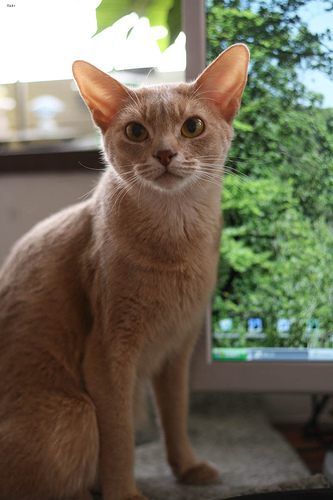

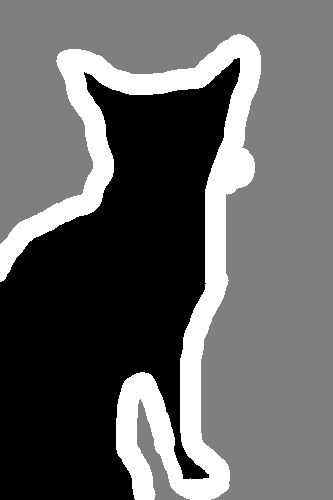

In [5]:
from IPython.display import Image,display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

display(Image(filename=input_img_paths[19]))

img=PIL.ImageOps.autocontrast(load_img(target_img_paths[19]))
display(img)

In [6]:
img=load_img(input_img_paths[1],target_size=(180,180))
a = np.asarray(img)
a.shape

NameError: ignored

In [7]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

class OxfordPets(keras.utils.Sequence):

  def __init__(self,batch_size,img_size,input_img_paths,target_img_paths):
    self.batch_size=batch_size
    self.img_size = img_size
    self.input_img_paths = input_img_paths
    self.target_img_paths = target_img_paths

  def __len__(self):
    return len(self.target_img_paths)//self.batch_size

  def __getitem__(self,idx):
    i = idx*self.batch_size
    batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
    batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]
    x=np.zeros((self.batch_size,)+self.img_size+(3,),dtype="float32")
    for j, path in enumerate(batch_input_img_paths):
      img=load_img(path,target_size=self.img_size)
      x[j]=img
    y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
    for j, path in enumerate(batch_target_img_paths):
      img=load_img(path,target_size=self.img_size,color_mode="grayscale")
      y[j]=np.expand_dims(img,2)
      y[j] -=1

    return x,y

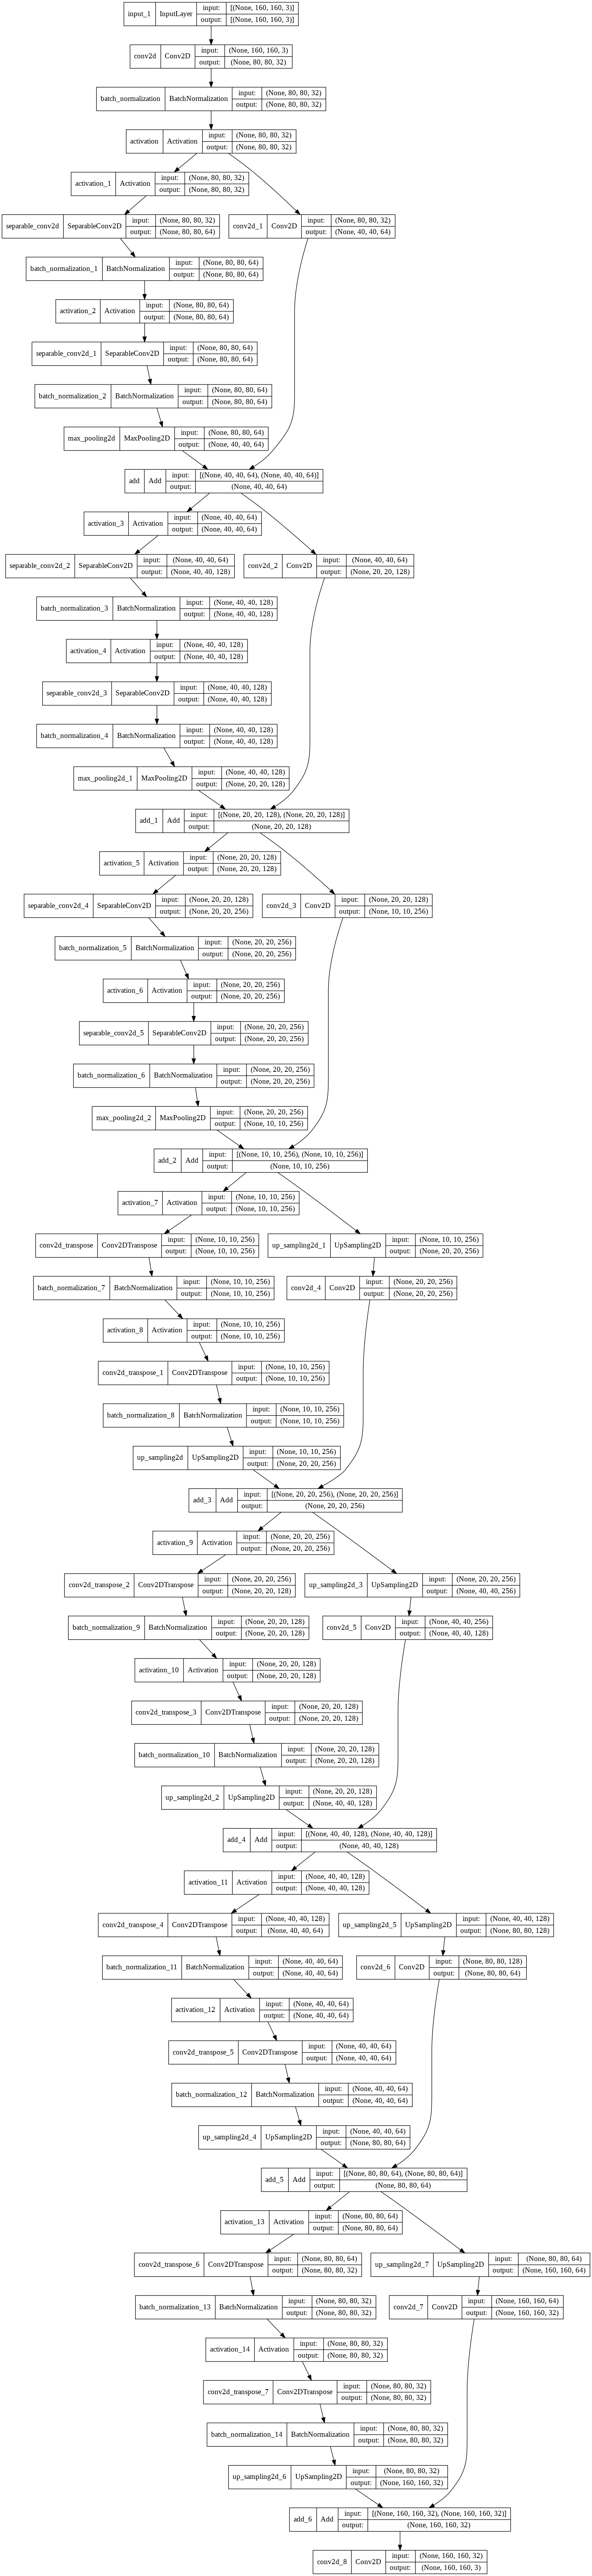

In [8]:
from tensorflow.keras import layers

def get_model(img_size,num_classes):
  inputs= keras.Input(shape=img_size+(3,))
  x=layers.Conv2D(32,3,strides=2,padding="same")(inputs)
  x=layers.BatchNormalization()(x)
  x=layers.Activation("relu")(x)

  previous_block_activation = x

  for filters in [64,128,256]:
    x=layers.Activation("relu")(x)
    x=layers.SeparableConv2D(filters,3,padding="same")(x)
    x=layers.BatchNormalization()(x)

    x=layers.Activation("relu")(x)
    x=layers.SeparableConv2D(filters,3,padding="same")(x)
    x=layers.BatchNormalization()(x)

    x=layers.MaxPooling2D(3,strides=2,padding="same")(x)
    
    residual=layers.Conv2D(filters,1,strides=2,padding="same")(previous_block_activation)

    x=layers.add([x,residual])
    previous_block_activation=x

  for filters in [256,128,64,32]:
    x=layers.Activation("relu")(x)
    x=layers.Conv2DTranspose(filters,3,padding="same")(x)
    x=layers.BatchNormalization()(x)

    x=layers.Activation("relu")(x)
    x=layers.Conv2DTranspose(filters,3,padding="same")(x)
    x=layers.BatchNormalization()(x)

    x=layers.UpSampling2D(2)(x)

    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters,1,padding="same")(residual)
    x = layers.add([x, residual])  
    previous_block_activation=x

  outputs=layers.Conv2D(num_classes,3,activation="softmax",padding="same")(x)

  model=keras.Model(inputs,outputs)
  return model

keras.backend.clear_session()

model=get_model(img_size,num_classes)
keras.utils.plot_model(model,show_shapes=True)

In [9]:
import random

val_samples=1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths=input_img_paths[:-val_samples]
train_target_img_paths=target_img_paths[:-val_samples]

val_input_img_paths=input_img_paths[-val_samples:]
val_target_img_paths=target_img_paths[-val_samples:]


train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [44]:
val_gen

In [10]:
model.compile(optimizer="rmsprop",loss="sparse_categorical_crossentropy")
callbacks=[keras.callbacks.ModelCheckpoint("oxford_segmentaion.h5",save_best_only=True)]
epochs=15
model.fit(train_gen,epochs=epochs,validation_data=val_gen,callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - ETA: 0s - loss: 0.8899

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


199/199 [==============================] - 104s 436ms/step - loss: 0.8899 - val_loss: 3.5095
Epoch 2/15
199/199 [==============================] - 86s 430ms/step - loss: 0.4931 - val_loss: 2.5503
Epoch 3/15
199/199 [==============================] - 85s 429ms/step - loss: 0.4235 - val_loss: 0.5279
Epoch 4/15
199/199 [==============================] - 85s 428ms/step - loss: 0.3796 - val_loss: 0.4250
Epoch 5/15
199/199 [==============================] - 85s 428ms/step - loss: 0.3462 - val_loss: 0.4486
Epoch 6/15
199/199 [==============================] - 86s 429ms/step - loss: 0.3163 - val_loss: 0.3947
Epoch 7/15
199/199 [==============================] - 85s 429ms/step - loss: 0.2893 - val_loss: 0.3788
Epoch 8/15
199/199 [==============================] - 85s 428ms/step - loss: 0.2695 - val_loss: 0.3836
Epoch 9/15
199/199 [==============================] - 85s 427ms/step - loss: 0.2534 - val_loss: 0.3804
Epoch 10/15
199/199 [==============================] - 85s 427ms/step - loss: 0.239

In [23]:
val_gen=OxfordPets(batch_size,img_size,val_input_img_paths,val_target_img_paths)
val_preds=model.predict(val_gen)

def displaymask(i):
  mask=np.argmax(val_preds[i],axis=-1)
  print(mask.shape)
  mask=np.expand_dims(mask,axis=-1)
  print(mask.shape)
  img=PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
  display(img)


  

(160, 160)
(160, 160, 1)


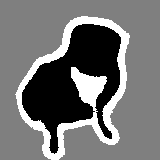

In [24]:
displaymask(10)

In [20]:
val_preds[10].shape

(160, 160, 3)